Model 2 - Standard ResNet Summary

*   **Architecture:** ResNet9 with two main residual blocks

*   **Filter Progression:** 64→128→256→512 channels (wider network)


*   **Pooling:** Uses MaxPooling for downsampling between stages

*   **Regularization:** L2 weight decay (1e-4) applied to all convolutional and dense layers

*   **Data Augmentation:** Basic augmentation with horizontal flips and translations

*   **Optimization:** Fixed learning rate with AdamW optimizer and gradient clipping

*   **Parameters:** Fewer layers but more filters per layer compared to standard ResNets. Batch size of 400. 

This implementation is a compact ResNet variant that hopefully achieves good performance on CIFAR-10 with a relatively small number of layers but wider filter sizes.

Notable Results (Validation Set):

*   Early Stopping at 35 Epochs
*   Average Loss: 0.367
*   Top 1 Error-rate: 0.111
*   Top 5 Error-rate: 0.004

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, ReLU, Add
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set seeds for reproducibility
np.random.seed(25)
tf.random.set_seed(25)

# Constants
batch_size = 400
num_classes = 10
input_shape = (32, 32, 3)
epochs = 50

# Download CIFAR-10 dataset using TensorFlow
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Calculate mean and std from training data instead of using hardcoded values
x_train_temp = x_train.astype('float32') / 255.0
mean = np.mean(x_train_temp, axis=(0, 1, 2))
std = np.std(x_train_temp, axis=(0, 1, 2))

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Normalize images
for i in range(3):
    x_train[:, :, :, i] = (x_train[:, :, :, i] - mean[i]) / std[i]
    x_test[:, :, :, i] = (x_test[:, :, :, i] - mean[i]) / std[i]

# Convert class vectors to binary class matrices (one-hot encoding)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Data augmentation (equivalent to transforms in PyTorch)
datagen = ImageDataGenerator(
    width_shift_range=0.125,  # Random crop of 32x32 from padded 36x36 (padding=4)
    height_shift_range=0.125,
    fill_mode='reflect',       # padding_mode='reflect'
    horizontal_flip=True       # RandomHorizontalFlip
)
datagen.fit(x_train)

# Define conv_block equivalent to PyTorch version
def conv_block(x, filters, pool=False, weight_decay=1e-4):
    x = Conv2D(filters, kernel_size=3, padding='same',
               kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    if pool:
        x = MaxPooling2D(2)(x)
    return x

# Define ResNet9 model using the Functional API
def ResNet9(weight_decay=1e-4):
    inputs = tf.keras.Input(shape=input_shape)

    # First block
    x = conv_block(inputs, 64, weight_decay=weight_decay)
    x = conv_block(x, 128, pool=True, weight_decay=weight_decay)

    # First residual block
    residual = x
    x = conv_block(x, 128, weight_decay=weight_decay)
    x = conv_block(x, 128, weight_decay=weight_decay)
    x = Add()([x, residual])

    # Middle blocks
    x = conv_block(x, 256, pool=True, weight_decay=weight_decay)
    x = conv_block(x, 512, pool=True, weight_decay=weight_decay)

    # Second residual block
    residual = x
    x = conv_block(x, 512, weight_decay=weight_decay)
    x = conv_block(x, 512, weight_decay=weight_decay)
    x = Add()([x, residual])

    # Classifier
    x = MaxPooling2D(4)(x)
    x = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax',
                   kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Create the model
model = ResNet9()

optimizer = tf.keras.optimizers.AdamW(
    learning_rate=0.001,
    clipnorm=0.1  # Gradient clipping
)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_accuracy')
    ]
)

# Set up callback - only early stopping with best weights restoration
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=7,
    restore_best_weights=True,  # This will restore the best weights at the end
    verbose=1,  # Set to 1 to see early stopping messages
    mode='max'
)

# Train the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping],  # Only using early stopping
    verbose=1  # Keep the default progress bar
)

# Evaluate the model
test_loss, test_acc, test_top5_acc = model.evaluate(x_test, y_test, verbose=1)
print(f"\nFinal Test Metrics:")
print(f"Loss: {test_loss:.4f}")
print(f"Top-1 Error Rate: {(1-test_acc):.4f} (Accuracy: {test_acc:.4f})")
print(f"Top-5 Error Rate: {(1-test_top5_acc):.4f} (Accuracy: {test_top5_acc:.4f})")


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 331ms/step - accuracy: 0.3955 - loss: 2.6002 - top5_accuracy: 0.8425 - val_accuracy: 0.3963 - val_loss: 1.8605 - val_top5_accuracy: 0.8996
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 34s 270ms/step - accuracy: 0.6948 - loss: 1.0671 - top5_accuracy: 0.9747 - val_accuracy: 0.6285 - val_loss: 1.2256 - val_top5_accuracy: 0.9578
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 263ms/step - accuracy: 0.7593 - loss: 0.8780 - top5_accuracy: 0.9831 - val_accuracy: 0.7518 - val_loss: 0.9031 - val_top5_accuracy: 0.9824
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 261ms/step - accuracy: 0.8078 - loss: 0.7373 - top5_accuracy: 0.9902 - val_accuracy: 0.7585 - val_loss: 0.9191 - val_top5_accuracy: 0.9771
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 34s 268ms/step - accuracy: 0.8271 - loss: 0.6846 - top5_accuracy: 0.9922 - val_accuracy: 0.7859 - val_loss: 0.8277 - val_top5_accuracy: 0.9878
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 34s 268ms/step - accuracy: 0.8438 - loss: 0.6

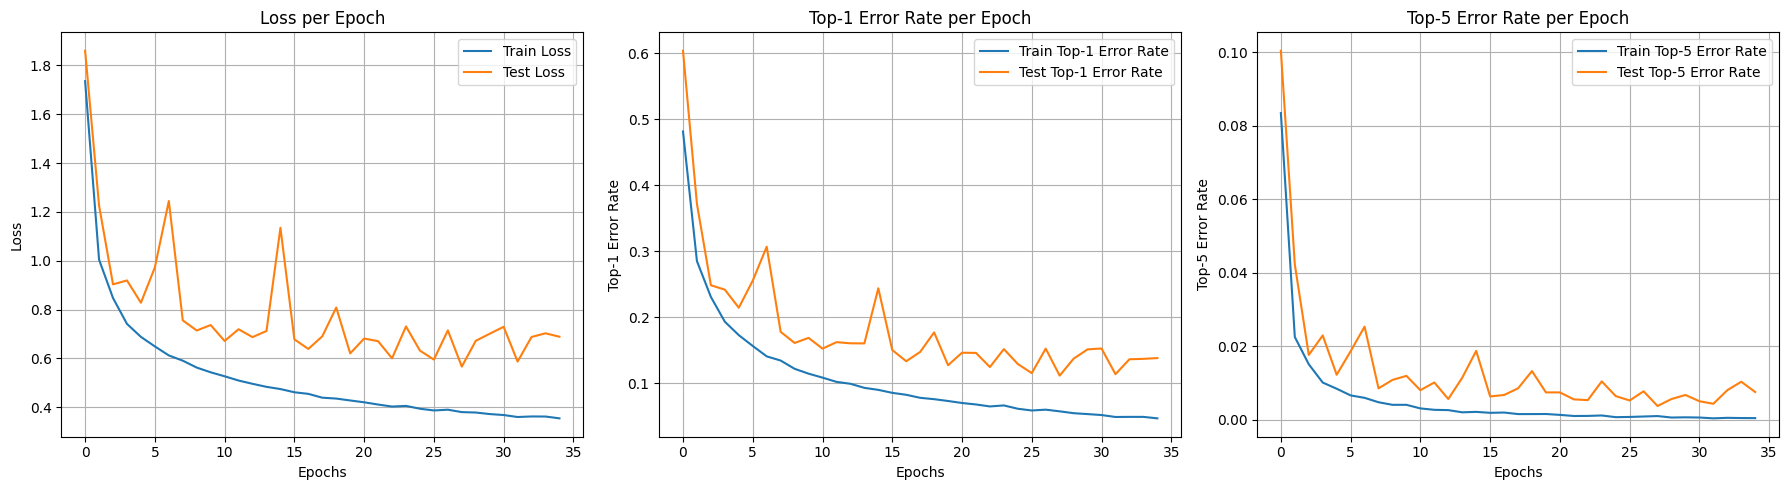

In [3]:
# Plot training & validation metrics
plt.figure(figsize=(18, 5))

# Define colors to match the reference image
train_color = 'tab:blue'
test_color = 'tab:orange'  # This is the orange color you want

# Plot 1: Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], color=train_color, label='Train Loss')
plt.plot(history.history['val_loss'], color=test_color, label='Test Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Top-1 Error Rate
plt.subplot(1, 3, 2)
train_top1_error = [1.0 - acc for acc in history.history['accuracy']]
val_top1_error = [1.0 - acc for acc in history.history['val_accuracy']]
plt.plot(train_top1_error, color=train_color, label='Train Top-1 Error Rate')
plt.plot(val_top1_error, color=test_color, label='Test Top-1 Error Rate')
plt.title('Top-1 Error Rate per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Top-1 Error Rate')
plt.legend()
plt.grid(True)

# Plot 3: Top-5 Error Rate
plt.subplot(1, 3, 3)
train_top5_error = [1.0 - acc for acc in history.history['top5_accuracy']]
val_top5_error = [1.0 - acc for acc in history.history['val_top5_accuracy']]
plt.plot(train_top5_error, color=train_color, label='Train Top-5 Error Rate')
plt.plot(val_top5_error, color=test_color, label='Test Top-5 Error Rate')
plt.title('Top-5 Error Rate per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Top-5 Error Rate')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=300)  # Save a high-resolution image

When comparing Model 2 (Standard ResNet) to Model 1 (Simple CNN) for CIFAR-10 classification, there are several compelling reasons to prefer Model 2:

- Residual Architecture: The residual connections in Model 2 allow gradients to flow more effectively through the network during backpropagation. This addresses the vanishing gradient problem, which is particularly beneficial when working with the complex patterns in CIFAR-10 images.

- Wider Feature Maps: The 64→128→256→512 filter progression in Model 2 provides significantly greater representational capacity compared to Model 1's 32→64→128 progression. This allows the network to capture more detailed and varied features from CIFAR-10's diverse object classes.

- Advanced Optimization: The AdamW optimizer with gradient clipping in Model 2 typically provides more stable training compared to standard Adam, especially important for the complex feature interactions in object recognition tasks.

- Weight Decay Regularization: The L2 regularization in Model 2 encourages the model to learn simpler, more generalizable patterns rather than memorizing the training data, which helps with CIFAR-10's limited training examples per class.
Data Augmentation: Even the basic augmentation in Model 2 helps increase the effective training set size and improves generalization across different object orientations and positions.

- Larger Batch Size: The 400 batch size in Model 2 (versus 32 in Model 1) allows for more stable gradient estimates during training, which often leads to better convergence on CIFAR-10.

- Parameter Efficiency: Despite having wider filters, the skip connections in Model 2 actually provide better information flow with fewer total layers, creating a better depth-to-performance ratio.

These advantages typically translate to significant performance improvements on CIFAR-10, with ResNet architectures generally achieving 5-10% higher accuracy than traditional CNNs, along with faster convergence during training.